<a href="https://colab.research.google.com/github/AodhanGallagher/XAI-for-Diabetic-Retinopathy-Diagnosis/blob/main/ModelTraining/Resnet50_Retinopathy_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Training and Evaluation**
This file is for the fine-tuning and transfer of a pretrained ResNet-50 model (trained using ImageNet),
so that it can be adjusted for retinographs and trained to detect and classify Diabetic Retinopathy from said retinographs. This fine-tuned model is then evaluated and saved.
\
\
Google Colab was used for the increased computation power needed to efficiently work on this project.

## Mounting Google Drive

In [ ]:
# Importing and mounting my Google Drive account where the dataset is stored
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Model Training

### Imports + Seed and Settings Configuration

In [ ]:
# Importing relevant libraries for getting, fine-tuning and training the model
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import shap
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.preprocessing import label_binarize
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from scipy import interp
from itertools import cycle

# Defining function to set seeds in order to make this experiment reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Setting seed to 0 for this experiment.
seed = 0
seed_everything(seed)

# Configuring matplotlib parameters so they appear in the notebook and with appropriate style set
%matplotlib inline
sns.set(style="whitegrid")

# Ignoring warnings that are thrown
warnings.filterwarnings("ignore")

### Loading and Preparing the Data

In [ ]:
# Getting the train and test set
# NOTE: The set path name used in this .ipynb file is for accessing the dataset within my own google drive,
# this path name can be changed to match the storage location of the APTOS dataset on other devices
df_train = pd.read_csv('/content/gdrive/MyDrive/Dissertation/final-year-project-AodhanGallagher/Datasets/ProcessedAPTOS/train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/Dissertation/final-year-project-AodhanGallagher/Datasets/ProcessedAPTOS/test.csv')

# Printing number of train and test samples to confirm they have been read in correctly
print('Number of train samples: ', df_train.shape[0])
print('Number of test samples: ', df_test.shape[0])

# Appending .png at the end of the id code and converting the diagnosis to a string
# for ease of use in training the model
df_train["id_code"] = df_train["id_code"].apply(lambda x: x + ".png")
df_test["id_code"] = df_test["id_code"].apply(lambda x: x + ".png")
df_train['diagnosis'] = df_train['diagnosis'].astype('str')

# Displaying dataframe values to ensure they were updsted correctly
display(df_train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


### Parameter Setting

In [ ]:
# Setting the model's parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
CANAL = 3
N_CLASSES = df_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

# Setting image size parameters
HEIGHT = 224
WIDTH = 224

### Train-Test Split

In [ ]:
# Splitting the data into training and validation sets (80% training and 20% validation)
train_x, valid_x = train_test_split(df_train, test_size=0.2, random_state=seed)

### Creating Data Generators with Data Augmentation

In [ ]:
# The following code acts as "data generators" which loads images in batches from their respective dataframes
# and applies data augmentation techniques (e.g. rotating and flipping) to these images
# This is done primarily to avoid overfitting and also to improve generalisation.

# Creating ImageDataDenerator object with pixel scaling, full rotation and image flipping enabled (for the train set)
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=360, horizontal_flip=True, vertical_flip=True)

# Creating the generator for the train set samples with the appropriate parameters
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_x,
    directory="/content/gdrive/MyDrive/Dissertation/final-year-project-AodhanGallagher/Datasets/ProcessedAPTOS/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0)


# Creating ImageDataDenerator object with pixel scaling enabled (for the validation set)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Creating the generator for the validation set samples with the appropriate parameters
valid_generator = validation_datagen.flow_from_dataframe(
    dataframe=valid_x,
    directory="/content/gdrive/MyDrive/Dissertation/final-year-project-AodhanGallagher/Datasets/ProcessedAPTOS/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0)


# Creating ImageDataDenerator object with pixel scaling enabled (for the test set)
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating the generator for the test set samples with the appropriate parameters
test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory = "/content/gdrive/MyDrive/Dissertation/final-year-project-AodhanGallagher/Datasets/ProcessedAPTOS/test_images/",
        x_col="id_code",
        batch_size=1,
        class_mode=None,
        shuffle=False,
        target_size=(HEIGHT, WIDTH),
        seed=0)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


### Model Creation and Training

#### Creating a ResNet-50 Model with Pre-trained Weights

In [ ]:
# Function used to create a deep learning model which uses the ResNet-50 architecture as a base,
# with additional layers on top for classification tasks (for use in our multi-class classification of Diabetic Retinopathy)
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, include_top=False, input_tensor=input_tensor)
    base_model.load_weights('/content/gdrive/MyDrive/Dissertation/final-year-project-AodhanGallagher/ModelTraining/ModelWeights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)

    return model

#### Training Top 5 Layers of Model

In [ ]:
# Creating our model for Diabetic Retinopathy classification
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

# Setting all the layers in the model to be untrainable - this freezes their weights during training
for layer in model.layers:
    layer.trainable = False

# Looping over the last 5 layers in the model and allowing them to be trainable during the training process
# This is done to fine-tune the weights of the last 5 layers to adapt the model for multi-class classification of DR
for i in range(-5, 0):
    model.layers[i].trainable = True

# Computing the class weights based on the class distribution of the train set
# This is done to address class imbalance and ensure the model is not biased towards more frequent classes
# This is especially important with the APTOS dataset used as there is a class imbalance, with class 0 (no DR)
# appearing much more frequently than all the other classes combined
class_weights = class_weight.compute_class_weight(
                                class_weight = 'balanced',
                                classes = np.unique(df_train['diagnosis'].astype('int').values),
                                y = df_train['diagnosis'].astype('int').values
                                )

# Organising the class weights in a dictionary with each class matched to its corresponding weight
class_weights = {i : class_weights[i] for i in range(5)}

metric_list = ["accuracy"] # Setting the evaluation metric to show the accuracy of the model
optimizer = optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE) # Initialising the Adam optimiser with the warmup learning rate of 1e-3

# Compiling the deep learning model with an optimizer, loss function and evaluation metric
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)

#### 'Warming Up' the Model

In [ ]:
# Calculating the number of steps needed to complete one epoch for the training and validation set
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

# Warmup training the model with lower learning rate and lower number of epochs
# to stabilise training and avoid getting stuck in local minima
history_warmup = model.fit_generator(generator=train_generator,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data=valid_generator,
                            validation_steps=STEP_SIZE_VALID,
                            epochs=WARMUP_EPOCHS,
                            class_weight=class_weights,
                            verbose=1).history

Epoch 1/2
366/366 [==============================] - 1780s 5s/step - loss: 2.3454 - accuracy: 0.2746 - val_loss: 1.2684 - val_accuracy: 0.4739
Epoch 2/2
366/366 [==============================] - 44s 121ms/step - loss: 1.7478 - accuracy: 0.3143 - val_loss: 1.1534 - val_accuracy: 0.4560


#### Fine-tuning the Full Model

In [ ]:
# The following code is used to fine-tune the completed model

# Setting all the layers in the model to be trainable
for layer in model.layers:
    layer.trainable = True

# Callback to stop model training if the 'val_loss' metric stops improving after a set amount of epochs (to avoid overfitting)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)

# Callback to reduce the learning rate if the 'val_loss' metric stops improving after a set amount of epochs (to avoid getting stuck in local minima)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop] # Initialising callback list with the above callbacks
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE) # Initialising the Adam optimiser with the learning rate of 1e-4

# Compiling the deep learning model with an optimizer, loss function and evaluation metric
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)

#### Training the Model

In [ ]:
# Training the model using a generator-based training approach, with the early stopping and learning rate adjustment callbacks
history_finetuning = model.fit_generator(generator=train_generator,
                                            steps_per_epoch=STEP_SIZE_TRAIN,
                                            validation_data=valid_generator,
                                            validation_steps=STEP_SIZE_VALID,
                                            epochs=EPOCHS,
                                            callbacks=callback_list,
                                            class_weight=class_weights,
                                            verbose=1).history

# Print statement to confirm model has been successfully trained
print("Model Trained")

Epoch 1/40
366/366 [==============================] - 75s 123ms/step - loss: 2.2597 - accuracy: 0.5351 - val_loss: 5.6950 - val_accuracy: 0.4821 - lr: 1.0000e-04
Epoch 2/40
366/366 [==============================] - 45s 123ms/step - loss: 1.1389 - accuracy: 0.6166 - val_loss: 1.0644 - val_accuracy: 0.5440 - lr: 1.0000e-04
Epoch 3/40
366/366 [==============================] - 45s 121ms/step - loss: 1.0247 - accuracy: 0.6631 - val_loss: 0.7763 - val_accuracy: 0.6745 - lr: 1.0000e-04
Epoch 4/40
366/366 [==============================] - 44s 121ms/step - loss: 0.9782 - accuracy: 0.6823 - val_loss: 0.8267 - val_accuracy: 0.7005 - lr: 1.0000e-04
Epoch 5/40
366/366 [==============================] - 44s 121ms/step - loss: 0.9318 - accuracy: 0.6939 - val_loss: 0.8578 - val_accuracy: 0.6951 - lr: 1.0000e-04
Epoch 6/40
366/366 [==============================] - ETA: 0s - loss: 0.8948 - accuracy: 0.7145
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
366/366 [=========

## Model Evaluation

### Overall Model Loss and Accuracy

In [ ]:
# Printing the overall accuracy and validation loss
print('Accuracy:', history_finetuning['accuracy'][-1])
print('Validation Loss:', history_finetuning['val_loss'][-1])

Accuracy: 0.8123930096626282
Validation Loss: 0.7132813334465027


### Model Accuracy and Validation Loss Graph

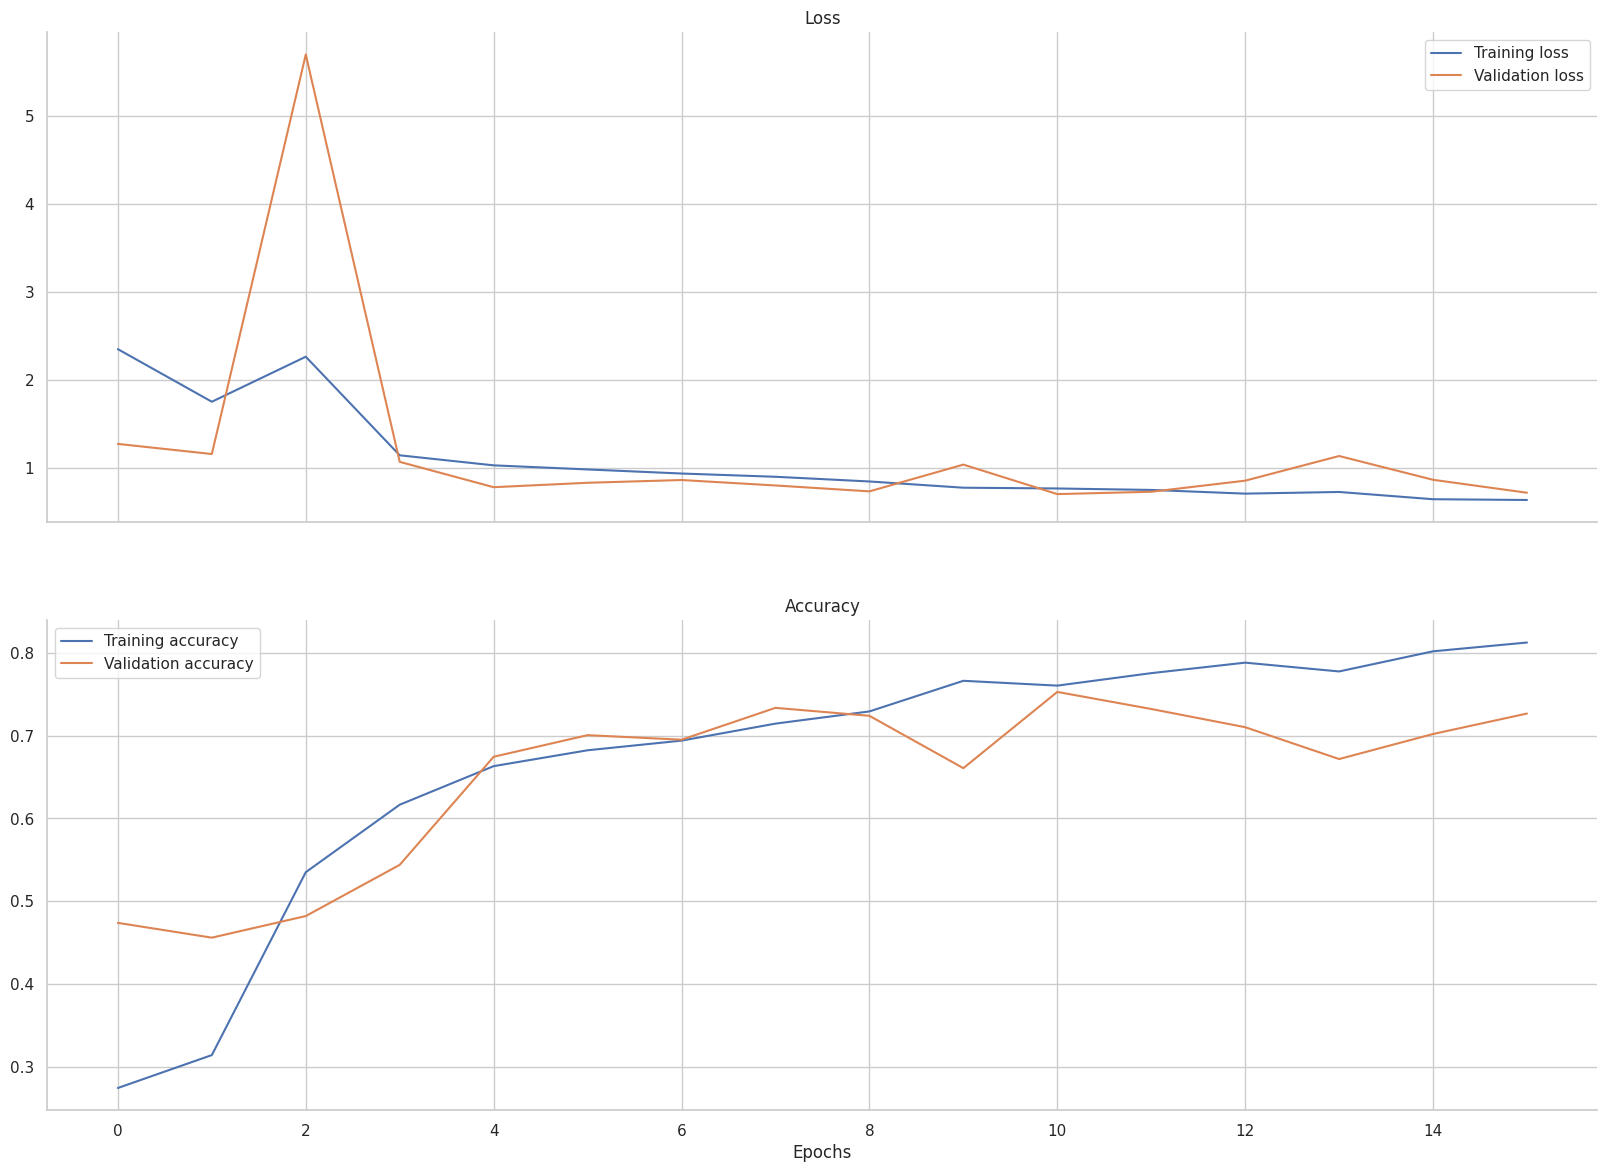

In [ ]:
# Plotting a line graph to show the model loss

# Creating dictionary to house the training history (formed from both warm up and actual training history by concatenation)
history = {'loss': history_warmup['loss'] + history_finetuning['loss'],
           'val_loss': history_warmup['val_loss'] + history_finetuning['val_loss'],
           'accuracy': history_warmup['accuracy'] + history_finetuning['accuracy'],
           'val_accuracy': history_warmup['val_accuracy'] + history_finetuning['val_accuracy']}

# Creating a matplotlib figure with two subplots and setting the plot style to 'whitegrid'
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

# Plotting the training loss, validation losses, legend and title on the first subplot
ax1.plot(history['loss'], label='Training loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

# Plotting the training accuracy, validation accuracy, legend and title on the second subplot
ax2.plot(history['accuracy'], label='Training accuracy')
ax2.plot(history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs') # Setting x-label
sns.despine() # Removing figure spines
plt.show() # Showing the plot

### Confusion Matrix

In [ ]:
# The following code is used to create labels and calculate data to be used in a confusion matrix
# in order to evaluate the model

# Creating empty arrays for labels and predictions
lastFullTrainPred = np.empty((0, N_CLASSES))
lastFullTrainLabels = np.empty((0, N_CLASSES))
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

# Adding the training labels and predictions
for i in range(STEP_SIZE_TRAIN+1):
    im, lbl = next(train_generator)
    scores = model.predict(im, batch_size=train_generator.batch_size)
    lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
    lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

# Adding the validation labels and predictions
for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)


lastFullComPred = np.concatenate((lastFullTrainPred, lastFullValPred)) # Concatenating predictions
lastFullComLabels = np.concatenate((lastFullTrainLabels, lastFullValLabels)) # Concatenating labels
complete_labels = [np.argmax(label) for label in lastFullComLabels] # Changing the concatenated labels to a list of class labels

# Changing the concatenated labels and predictions into class labels for both the training and validation sets
train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
train_labels = [np.argmax(label) for label in lastFullTrainLabels]
validation_preds = [np.argmax(pred) for pred in lastFullValPred]
validation_labels = [np.argmax(label) for label in lastFullValLabels]

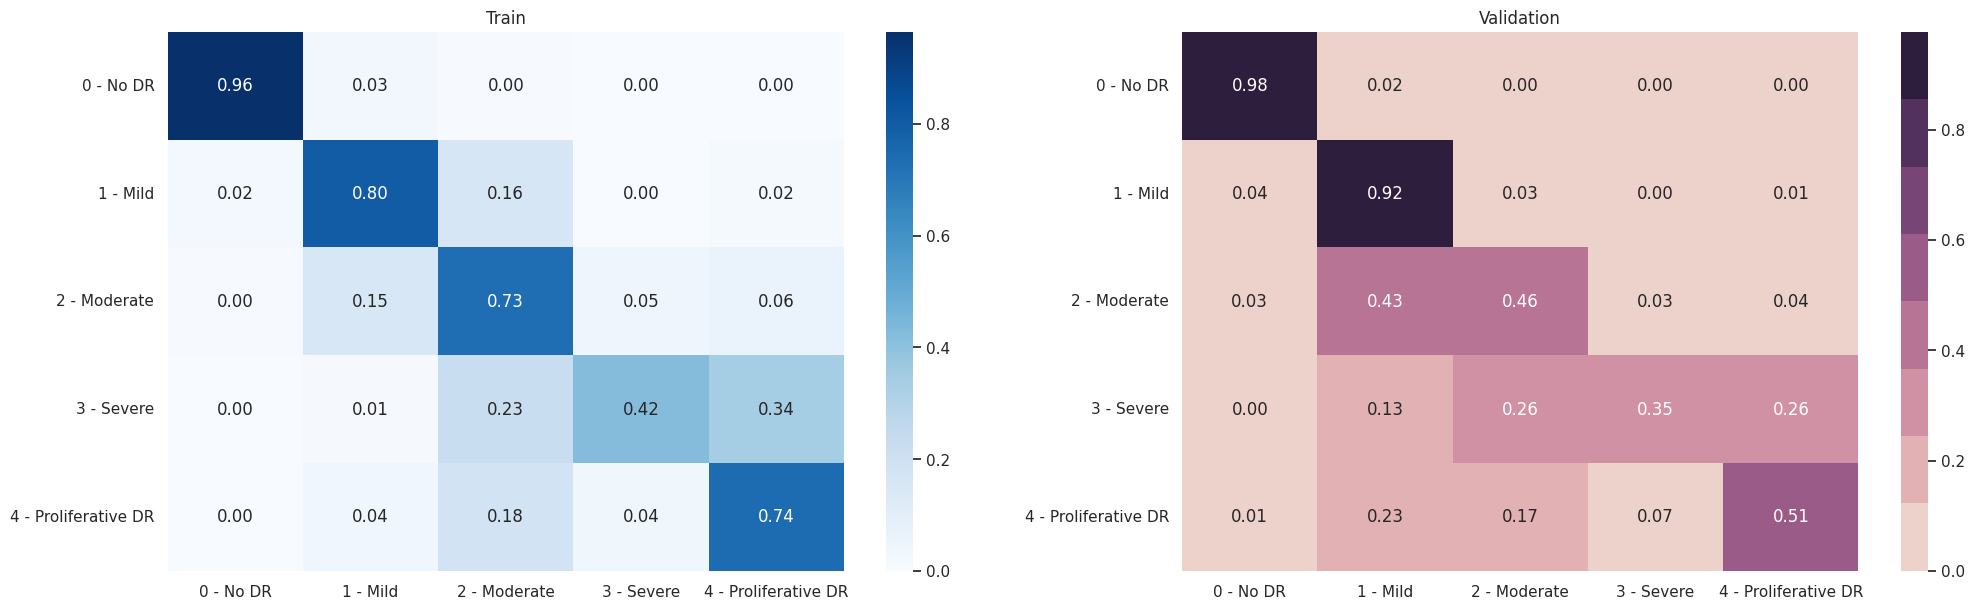

In [ ]:
# The following code is used to create and plot the two confusion matrices

fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7)) # Creating figure with two subplots
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR'] # Defining labels
train_cnf_matrix = confusion_matrix(train_labels, train_preds) # Creating confusion matrix for train set
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds) # Creating confusion matrix for validation set

# Normalising the two confusion matrices
train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

# Creating dataframes of the two normalised confusion matrices
train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

# Adding heatmap visualisations (blue and red) and a title to the two normalised confusion matrices, then showing the final plot
sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax1).set_title('Train')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8), ax=ax2).set_title('Validation')
plt.show()

### Cohen Kappa Scores

In [ ]:
# Calculating and printing the Cohen Kappa score for the training and validation sets, as well as the overall score
print("Training Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds,train_labels, weights='quadratic'))
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
print("Overall Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds+validation_preds, train_labels+validation_labels, weights='quadratic'))

Training Cohen Kappa score: 0.911
Validation Cohen Kappa score: 0.821
Overall Cohen Kappa score: 0.893


## Saving the Trained Model

In [ ]:
# Saving the trained model for future use
model.save('/content/gdrive/MyDrive/Dissertation/final-year-project-AodhanGallagher/ModelTraining/Models/diabetic_retinopathy_classifier.keras')

# Confirming that the model was saved
print("Model Saved")

Model Saved


## Testing the Model's Diagnoses on the Test Set

In [ ]:
# Resetting the test generator and calculating the step size for the test set
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

# Generating predictions for the test set and converting the prediction probabilities into class labels
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

filenames = test_generator.filenames # Retrieving filenames from the test generator
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions}) # Creating a dataframe with columns for filename and (predicted) diagnosis
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4]) # Removing extensions (.png) from the filename

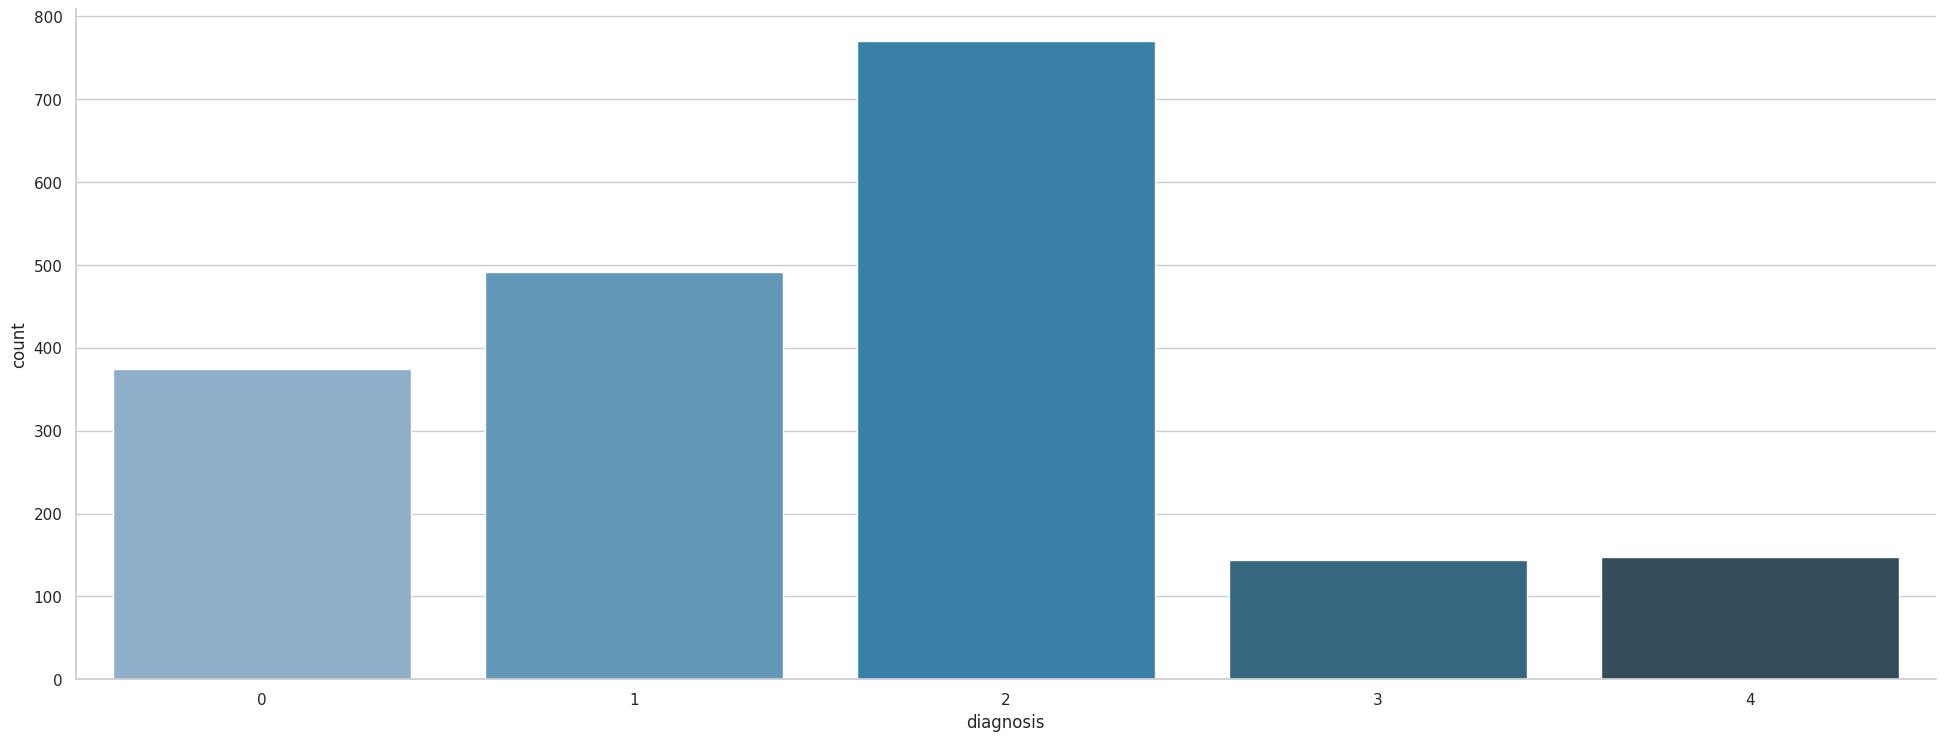

In [ ]:
# Creating barchart and configuring it to display the class distribution of the predictions
fig = plt.subplots(1, 1, sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="PuBu_d")
sns.despine()
plt.show()